# 과제#1. 더반찬 주문량 예측

* 비지니스 상황
    * 반찬 판매량 예측을 통한 페기비용 및 기회상실 비용 절감
    * 오더 시점의 주문량이 타겟이 아니라 희망배송일의 주문량이 타겟이 됨
    * 예측 범위: 월~토(주간 예측모델): 매주 일요일 혹은 월요일 새벽에 가동된다는 가정
    * 모델 평가기간 2022-06-01 ~ 2022-06-30
    * 평가지표 R2, RMSE, 예측 정확도(abs(예측-실제)/실제)

&nbsp;
* 주의사항: Regression 사용시 미래에도 독립변수로 활용할 수 있는 인자를 사용해야함
           (예를 들어, 할인 판매 금액데이터는 미래 일주일 치를 받을 수 없음)

|	필드이름	|	유형	|	설명	|
|	----	|	----	|	----	|
|	ORD_NO 	|	STRING	|	order 시리얼 넘버	|   
|	H_YMD 	|	STRING	|	희망배송일	|  
|	O_YMD 	|	STRING	|	오더 시간	|  
|	PKG_GOODS_NO 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	PKG_GOODS_NM 	|	STRING	|	단품인지 세트인지 구성상품	|   
|	GOODS_NO 	|	STRING	|	자재코드	|   
|	GOODS_NM 	|	STRING	|	자재명	|   
|	STD_GSGR_NO_LEV1_NM 	|	 STRING	|	자재 카테고리	|   
|	ORD_QTY 	|	 INTEGER	|	오더건수	|   
|	CANCEL_QTY 	|	 INTEGER	|	취소 오더건수	|   
|	RET_QTY 	|	 INTEGER	|	환불 오더건수	|   
|	REAL_ORD_QTY 	|	 INTEGER	|	최종 오더건수	|   
|	RECVR_ROAD_BASE_ADDR 	|	 STRING	|	주소	|   
|	SALE_PRICE 	|	 INTEGER	|	판매가격	|   
|	DISCOUNT_AMT	|	 INTEGER	|	할인액  |   
|	FINAL-PRICE 	|	 INTEGER	|	최종 판매 가격	|   

## 가설


1. 가격이 낮을수록 판매량이 많을 것이다.
2. 할인액이 높을수록 판매량이 많을 것이다.
3. 계절별로 판매되는 제품의 수가 다를 것이다.
4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
7. 카테고리별로 판매량이 다를 것이다.
8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.
14. 유통기한이 긴 제품이 여름에 더 잘팔릴 것이다.
15. 평점이 높은 제품이 취소나 환불이 적을 것이다.

In [48]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

## 0. 환경준비

### 0.1 Import

In [1]:
# 기본 라이브러리 가져오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  

### 0.2 Data Loading

In [2]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [306]:
# 카피 데이터 생성
copy_data = raw_data.copy()

#copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
copy_data = copy_data.sort_values(by = 'H_YMD')

#copy_data.to_csv('C:\\Users\\user\\Desktop\\raw.csv', index=False, encoding='utf-8-sig')

copy_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
166288,119348,201912302355791,2020-01-01 00:00:00,2019-12-30 21:59:40,단품,단품,14375,옛날잡채(500g),메인요리,1,0,0,1,"경기도 수원시 장안구 경수대로976번길 22 (조원동, 수원 한일타운)",8600,1408.0,7192
37753,37753,201912302355557,2020-01-01 00:00:00,2019-12-30 20:50:07,단품,단품,1901012353,수제계란말이(350g),반찬,2,0,0,2,서울 성북구 동소문로34길 24 삼성아파트,6300,NaN,6300
162585,115645,201912302353567,2020-01-01 00:00:00,2019-12-30 11:02:39,단품,단품,1823,숙주나물(300g),반찬,1,0,0,1,"서울특별시 마포구 삼개로 33 (도화동, 도화3지구우성아파트)",3300,486.0,2814
164041,117101,201912302354611,2020-01-01 00:00:00,2019-12-30 15:19:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,경기도 용인시 수지구 문인로3번길 22 (풍덕천동),6900,264.0,6636
164040,117100,201912302352965,2020-01-01 00:00:00,2019-12-30 10:08:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,"경기도 구리시 아차산로487번길 27 (교문동, 아차산어울림아파트)",6900,317.0,6583


## 1. 데이터 탐색

### 1.1 데이터 확인

In [85]:
# 데이터의 정보 확인
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            724702 non-null  int64         
 1   ORD_NO                724702 non-null  int64         
 2   H_YMD                 724702 non-null  datetime64[ns]
 3   O_YMD                 724702 non-null  object        
 4   PKG_GOODS_NO          724702 non-null  object        
 5   PKG_GOODS_NM          724702 non-null  object        
 6   GOODS_NO              724702 non-null  int64         
 7   GOODS_NM              724702 non-null  object        
 8   STD_GSGR_NO_LEV1_NM   724702 non-null  object        
 9   ORD_QTY               724702 non-null  int64         
 10  CANCEL_QTY            724702 non-null  int64         
 11  RET_QTY               724702 non-null  int64         
 12  REAL_ORD_QTY          724702 non-null  int64         

In [86]:
# 결측치 확인 -> DISCOUNT_AMT변수에서 376247개의 결측치 확인
# 결측치라기 보다는 할인액이 없는, 할인되지 않은 상품으로 예상되어 0으로 대체해도 될 것 같음
copy_data.isna().sum()

Unnamed: 0                   0
ORD_NO                       0
H_YMD                        0
O_YMD                        0
PKG_GOODS_NO                 0
PKG_GOODS_NM                 0
GOODS_NO                     0
GOODS_NM                     0
STD_GSGR_NO_LEV1_NM          0
ORD_QTY                      0
CANCEL_QTY                   0
RET_QTY                      0
REAL_ORD_QTY                 0
RECVR_ROAD_BASE_ADDR         0
SALE_PRICE                   0
DISCOUNT_AMT            376247
FINAL_PRICE                  0
dtype: int64

In [87]:
#PKG_GOODS_NO 정보 확인 -> 단품외에 상품이 존재
### 단품 상품이 아닌 경우 코드가 어떤 제품을 나타내는지 알아볼 필요가 있음

copy_data['PKG_GOODS_NO'].value_counts()

단품            661716
2106015591      6049
2107015727      5599
2103015234      4837
2107015647      3474
               ...  
2205016968        11
2202016453         8
2106015460         5
2202016409         3
1908013238         2
Name: PKG_GOODS_NO, Length: 77, dtype: int64

In [88]:
# PKG_GOODS_NM 정보 확인 -> 골라담기, 내일한정, 한정판매, 신규, 세트 등이 있음
### 내일한정 같은 경우는 단품으로 분류해야 하지 않을까?
copy_data['PKG_GOODS_NM'].value_counts()

단품                                        661716
더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)           9540
더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)              5599
[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)      4837
[내일한정] 두메산나물비빔밥재료                           3099
                                           ...  
매콤막창볶음밥&채소계란찜 SET                             21
신규.싱글세트18-1                                   16
신규.패밀리세트8-2                                   11
[한정판매]키즈 set                                   8
[내일한정] 꼬막무침 (250g)                             5
Name: PKG_GOODS_NM, Length: 72, dtype: int64

In [89]:
#GOODS_NM 정보 확인
copy_data['GOODS_NM'].value_counts()
#copy_data['GOODS_NM'].value_counts().sum()

두메산나물비빔밥재료                    159184
옛날잡채(500g)                    112852
셀프두부조림(600g)                   48948
숙주나물(300g)                     43906
채소계란찜(340g)                    38440
한돈 제육볶음(700g)                  35142
수제계란말이(350g)                   33080
건표고버섯볶음                        29162
꼬막무침 (250g)                    26499
양장피                            25901
가정집 오징어불고기/셀프(380g)            24389
고소한도토리묵무침(265g)                21898
건고사리나물볶음(150g)                 17556
[심방골주부X더반찬] 시골 돼지짜글이(600g)     17382
고구마 품은 라자냐(450g)               16660
우삼겹숙주볶음(250g)                  15293
순살코다리강정(180g)                  14526
메밀소바(2인분)                      13860
열무비빔밥재료믹스(2인분)                  9915
꼬막무침 (260g)                     9284
고소한도토리묵무침(360g)                 4744
고사리나물볶음(150g)                   4182
소고기유니짜장소스(1인분, 200g)            1899
Name: GOODS_NM, dtype: int64

In [90]:
#STD_GSGR_NO_LEV1_NM wjdqh 정보 확인
copy_data['STD_GSGR_NO_LEV1_NM'].value_counts()

메인요리    362212
반찬      358623
국         3867
Name: STD_GSGR_NO_LEV1_NM, dtype: int64

### 1.2 데이터 보완하기

a) PKG_GOODS_NM의 데이터를 단품 or 세트로 대체해주는 작업 실시

In [12]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {'171201310' : '두메산나물비빔밥재료', '14375':	'옛날잡채(500g)', '3273':'채소계란찜(340g)', '13957':'셀프두부조림(600g)', '1901012353':'수제계란말이(350g)',
             '13529':'메밀소바(2인분)', '1803010879':'고소한도토리묵무침(265g)', '2012014895':'한돈 제육볶음(700g)', '2204016772':'소고기유니짜장소스(1인분, 200g)', 
             '1823':'숙주나물(300g)', '4092':'건표고버섯볶음', '14985':'양장피', '1808011751':'꼬막무침 (250g)', '1903012675':'순살코다리강정(180g)', 
             '2010014667':'우삼겹숙주볶음(250g)', '1806011271':'열무비빔밥재료믹스(2인분)', '2103015231':'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             '2010014707':'고구마 품은 라자냐(450g)', '1805011121':'건고사리나물볶음(150g)', '1909013359':'가정집 오징어불고기/셀프(380g)'
             }

In [251]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '[내일한정] 수제계란말이(350g)', '메밀소바+돈까스 SET', '[내일한정] 메밀소바(2인분)', '[특판] 웰스토리 전자레인지 조리세트', '잔치상 세트', '[심방골주부X더반찬] 한식밥상 2종 골라담기 (16,660원 부터~)', 'SK스토아 베스트 세트', '[내일한정] 셀프두부조림(600g)', '[내일한정] 숙주나물(300g)', '[내일한정] 고소한도토리묵무침(265g)', '[내일한정] 옛날잡채(500g)', '[내일한정] 한돈 제육볶음(700g)', '[내일한정] [심방골주부X더반찬] 시골 돼지짜글이(600g)', '[내일한정] 고구마 품은 라자냐(450g)', '[내일한정] 양장피', '[내일한정] 두메산나물비빔밥재료', '[내일한정] 가정집 오징어불고기/셀프(380g)', '[내일한정] 채소계란찜(340g)', '[내일한정] 우삼겹숙주볶음(250g)', '[내일한정] 순살코다리강정(180g)', '[내일한정] 건고사리나물볶음(150g)', '[내일한정] 건표고버섯볶음', '더반찬& 집밥만찬 2종 골라담기 (5,000원 부터~)', '한돈제육세트', '더반찬& 메인메뉴 1종 + 내맘대로 2종 골라담기(15,900원부터~)', '더반찬& 고메위크 골라담기', '열무비빔밥+된찌 SET', '저녁을 부탁해 세트 A', '더반찬& 인기 밑반찬 3종 골라담기 (7,500원 부터~)', '더반찬& 인기 시그니처 2종 골라담기 (5,000원 부터~)', '[내일한정] 열무비빔밥재료믹스(2인분)', '[내일한정] 꼬막무침 (250g)', '더반찬 베스트 C세트', '짭쪼름한 안주세트', '[한정판매] 두메산나물비빔밥재료', '[한정판매] 옛날잡채(500g)', '[더반찬] 주말 밥상세트 A', '[설날] 더반찬 프리미엄 차례상 (사용X)', '저녁을 부탁해 세트 B', '[내일한정] 꼬막무침 (260g)', '[내일한정] 고사리나물볶음(150g)', '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 s

In [307]:
# 내일한정, 한정판매는 단품으로 대체
# 한정판매 중에는 단품이 아닌 세트도 있어서 이를 유의해야 함(ex. '[한정판매]손님초대상 set', '[한정판매]반찬 한 상 set', '[한정판매]키즈 set')

# 내일한정이 붙은 제품은 모두 단품인 것을 확인하여 카테고리를 단품으로 바꿔줌, 
# [내일한정] 고소한도토리묵무침(265g), [내일한정] 건고사리나물볶음(150g), [내일한정] 꼬막무침 (250g)은 제외
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'

# 한정판매 중에서 두 제품만 단품이었기에 두 제품을 단품으로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'  
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 옛날잡채(500g)'] = '단품'

# 단품으로 바꿔주지 않은 모든 제품을 세트로 바꿔줌
copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] != '단품'] = '세트'

C:\Users\user\AppData\Local\Temp\ipykernel_6280\1220614922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'].str.contains('내일한정')] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_6280\1220614922.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_data['PKG_GOODS_NM'].loc[copy_data['PKG_GOODS_NM'] == '[한정판매] 두메산나물비빔밥재료'] = '단품'
C:\Users\user\AppData\Local\Temp\ipykernel_6280\1220614922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [282]:
GOODS_NM_dic = []

for i in copy_data['PKG_GOODS_NM']:
    if i not in GOODS_NM_dic:
        GOODS_NM_dic.append(i)

print(GOODS_NM_dic)

['단품', '세트']


In [309]:
#자재코드와 자재명 합치기
copy_data['GOODS'] = copy_data["GOODS_NO"].astype(str) + '_' +  copy_data['GOODS_NM']
copy_data.GOODS

166288                  14375_옛날잡채(500g)
37753            1901012353_수제계란말이(350g)
162585                   1823_숙주나물(300g)
164041             1712010310_두메산나물비빔밥재료
164040             1712010310_두메산나물비빔밥재료
                       ...              
236658        1803010879_고소한도토리묵무침(360g)
241774    1909013359_가정집 오징어불고기/셀프(380g)
236656        1803010879_고소한도토리묵무침(360g)
241810    1909013359_가정집 오징어불고기/셀프(380g)
237568         1806011271_열무비빔밥재료믹스(2인분)
Name: GOODS, Length: 724702, dtype: object

d) 불필요한 컬럼 제거

In [308]:
copy_data.columns 

Index(['Unnamed: 0', 'ORD_NO', 'H_YMD', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'GOODS_NO', 'GOODS_NM', 'STD_GSGR_NO_LEV1_NM',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'RECVR_ROAD_BASE_ADDR', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE'],
      dtype='object')

In [310]:
dummy_col = ['Unnamed: 0', 'O_YMD', 'ORD_NO', 'PKG_GOODS_NO', 'RECVR_ROAD_BASE_ADDR',
             'GOODS_NM', 'GOODS_NO']
copy_data = copy_data.drop(dummy_col, axis=1)

In [209]:
copy_data.tail()

,H_YMD,PKG_GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,GOODS
236658,2022-05-31 00:00:00,단품,메인요리,1,0,0,1,4500,NaN,4500,1803010879_고소한도토리묵무침(360g)
241774,2022-05-31 00:00:00,단품,메인요리,1,0,0,1,9900,1801.0,8099,1909013359_가정집 오징어불고기/셀프(380g)
236656,2022-05-31 00:00:00,단품,메인요리,1,0,0,1,4500,NaN,4500,1803010879_고소한도토리묵무침(360g)
241810,2022-05-31 00:00:00,단품,메인요리,1,0,0,1,9900,1490.0,8410,1909013359_가정집 오징어불고기/셀프(380g)
237568,2022-05-31 00:00:00,단품,반찬,1,0,0,1,8900,713.0,8187,1806011271_열무비빔밥재료믹스(2인분)


In [10]:
# 데이터 상관관계 분석
copy_data.corr()

,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
GOODS_NO,1.000000,0.009102,-0.012331,0.004310,0.015689,0.316799,0.202943,0.237327
ORD_QTY,0.009102,1.000000,0.206051,0.022218,0.826752,0.018099,0.140279,0.000686
CANCEL_QTY,-0.012331,0.206051,1.000000,-0.009708,-0.380136,-0.010178,0.032517,-0.022129
RET_QTY,0.004310,0.022218,-0.009708,1.000000,0.026582,0.003935,0.014294,-0.000072
REAL_ORD_QTY,0.015689,0.826752,-0.380136,0.026582,1.000000,0.022960,0.098884,0.013371
SALE_PRICE,0.316799,0.018099,-0.010178,0.003935,0.022960,1.000000,0.462131,0.830052
DISCOUNT_AMT,0.202943,0.140279,0.032517,0.014294,0.098884,0.462131,1.000000,-0.284285
FINAL_PRICE,0.237327,0.000686,-0.022129,-0.000072,0.013371,0.830052,-0.284285,1.000000


c:\Users\user\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

c:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


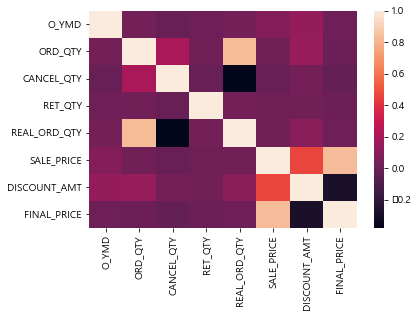

In [234]:
sns.heatmap(copy_data.corr())

### 1.3 단변량 분석

In [ ]:
# 1. 가격이 낮을수록 판매량이 많을 것이다.
# 2. 할인액이 높을수록 판매량이 많을 것이다.
# 3. 계절별로 판매되는 제품의 수가 다를 것이다.
# 4. 고단백 식품이 여름에 더 많이 팔릴 것이다.
# 5. 명절에 명절음식 뿐 아니라 다른 음식도 판매량이 늘 것이다.
# 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)
# 7. 카테고리별로 판매량이 다를 것이다.
# 8. 배달 주소건수 비율이 높은 지역은 취소나 환불이 적을 것이다.
# 9. 주문하는 시간대는 주로 퇴근시간대나 그 이후일 것이다.
# 10. 재철재료가 들어간 식품은 그 계절에 잘 팔릴 것이다.
# 11. 2022.06.02 대장균 검출 기사가 난 이후 판매량이 줄었을 것이다.
# 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
# 13. 주 고객층은 자녀를 둔 부모나 혼자사는 사람일 것이다.

In [130]:
# 그래프 한글깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'

In [235]:
#test_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv',  parse_dates=["H_YMD"])
test_data = copy_data.copy()

c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='REAL_ORD_QTY', ylabel='Density'>

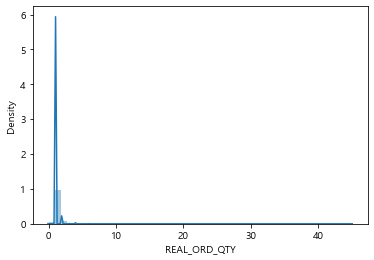

In [236]:
sns.distplot(test_data['REAL_ORD_QTY'])

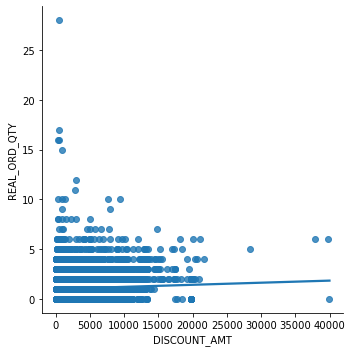

In [24]:
sns.lmplot(x='DISCOUNT_AMT', y='REAL_ORD_QTY', data=copy_data)

In [79]:
def extract_20_month(date):
    if date.year == 2020:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')

def extract_21_month(date):
    if date.year == 2021:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')

def extract_22_month(date): 
    if date.year == 2022:
        return str(date.year) + str('-') + str(date.month).rjust(2,'0')


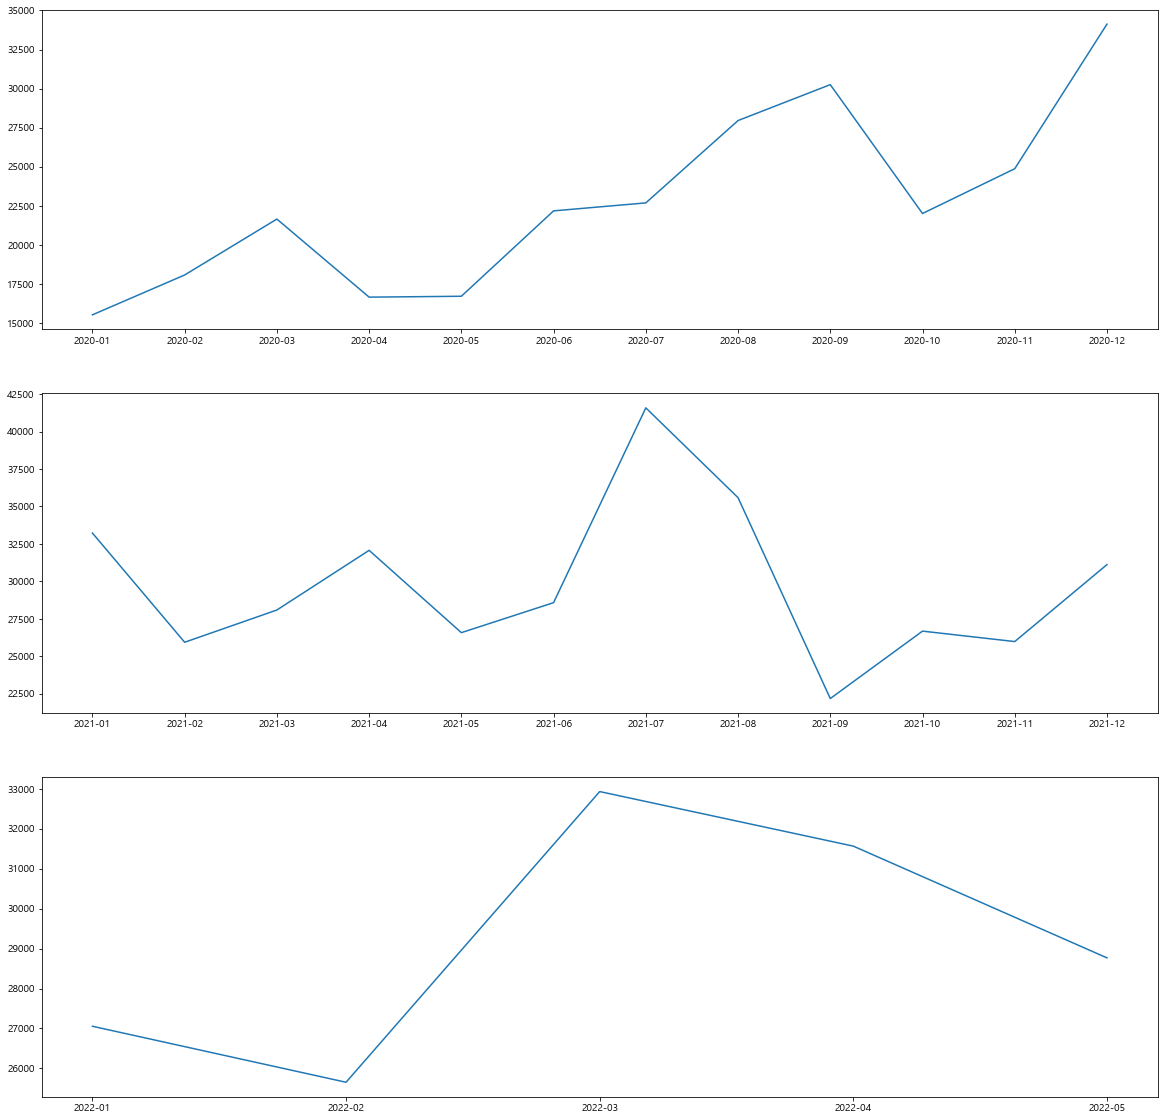

In [80]:
rev_by_20_month=test_data.set_index('H_DATETIME').groupby(extract_20_month).sum()['REAL_ORD_QTY']
rev_by_21_month=test_data.set_index('H_DATETIME').groupby(extract_21_month).sum()['REAL_ORD_QTY']
rev_by_22_month=test_data.set_index('H_DATETIME').groupby(extract_22_month).sum()['REAL_ORD_QTY']

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(rev_by_20_month)

plt.subplot(3,1,2)
plt.plot(rev_by_21_month)

plt.subplot(3,1,3)
plt.plot(rev_by_22_month)

- 12. 2021.06.15 새벽배송 시간이 연장되고 주문량이 늘었을 것이다.
- 6. 네고왕 홍보 이후(2022.05.26)에 판매량이 늘었을 것이다.(06.08 까지)

- 네고왕의 홍보와 새벽배송 서비스가 매우 효과적이었음을 확인할 수 있다. 
- 더반찬 어플의 경우 주 고객층의 연령대가 그리 높지 않을 것으로 추측되고, 개인부터 가족까지 그 범위가 다양하기 때문에
  그들을 공략할 수 있는 서비스와 홍보가 매우 중요하다는 것을 확인할 수 있었다.

In [81]:
test_data["O_DATETIME"] = pd.to_datetime(test_data["O_YMD"], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [82]:
def extract_20_hour(date):
    if date.year == 2020:
        return str(date.hour).rjust(2,'0')

def extract_21_hour(date):
    if date.year == 2021:
        return str(date.hour).rjust(2,'0')

def extract_22_hour(date):
    if date.year == 2022:
        return str(date.hour).rjust(2,'0')


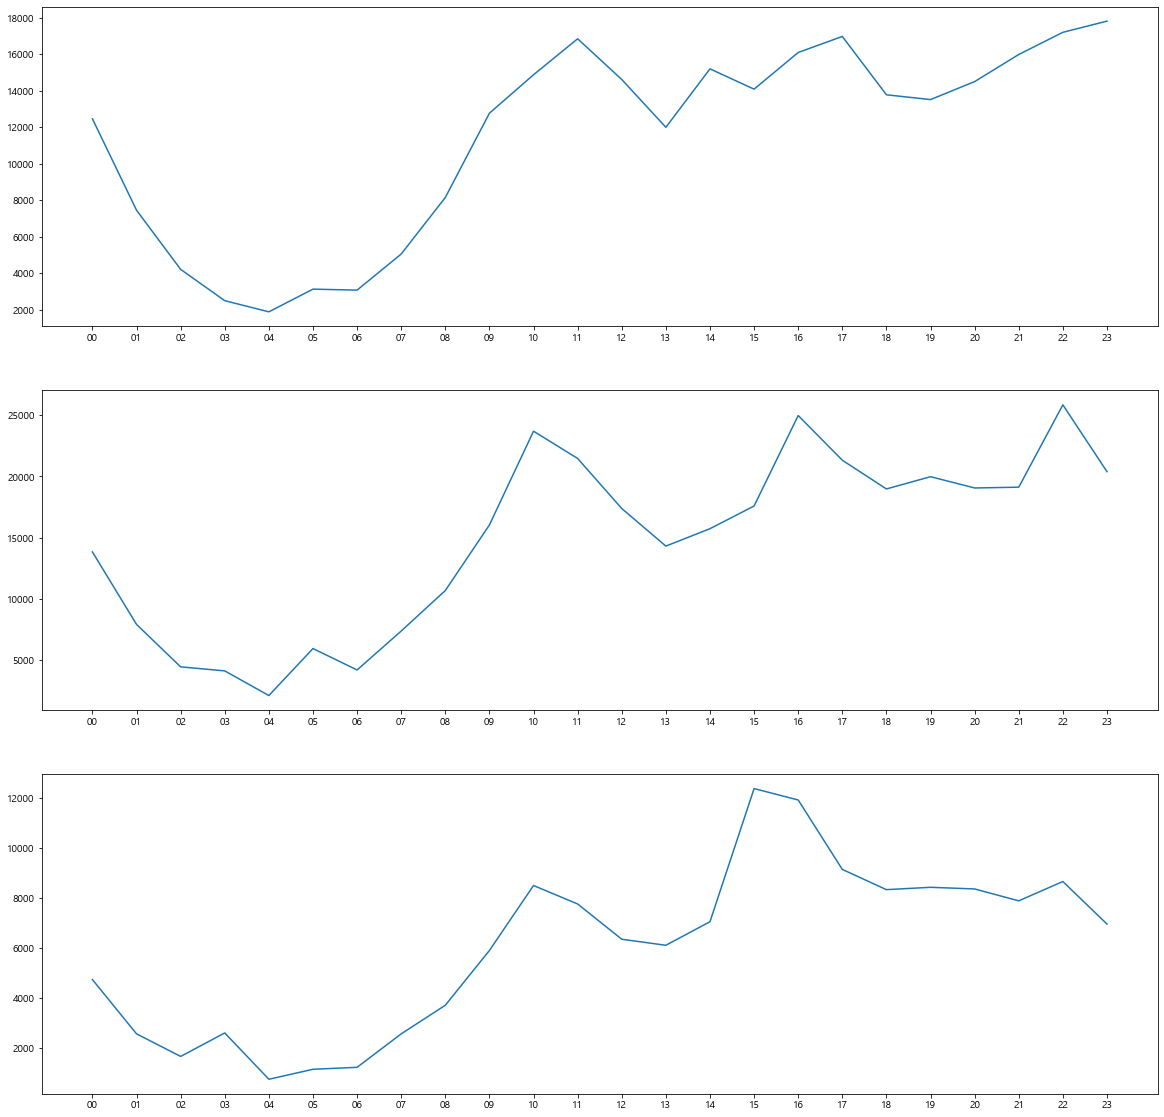

In [83]:
rev_by_20_hour=test_data.set_index('O_DATETIME').groupby(extract_20_hour).sum()['REAL_ORD_QTY']
rev_by_21_hour=test_data.set_index('O_DATETIME').groupby(extract_21_hour).sum()['REAL_ORD_QTY']
rev_by_22_hour=test_data.set_index('O_DATETIME').groupby(extract_22_hour).sum()['REAL_ORD_QTY']

plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(rev_by_20_hour)

plt.subplot(3,1,2)
plt.plot(rev_by_21_hour)

plt.subplot(3,1,3)
plt.plot(rev_by_22_hour)

- 주로 점심시간 직전, 저녁시간 직전에 주문 수가 많아지는 것을 확인할 수 있다.
- 배가고플 때 일반적으로 배달앱을 많이 키는 것처럼 더반찬 사이트에도 많이 접속하는 것으로 볼 수 있다.
- 사람들이 배가 고플 때 배달 어플이 아니라 더반찬 어플을 사용할 수 있는 이유을 만들어 주면 더 높은 매출을 달성할 수 있을것이다.

In [85]:
copy_data.groupby(["GOODS", "PKG_GOODS_NM"])['REAL_ORD_QTY'].sum().to_frame()

REAL_ORD_QTY
GOODS                                 PKG_GOODS_NM              
13529_메밀소바(2인분)                       단품                   14747
                                      세트                    1278
13957_셀프두부조림(600g)                    단품                   51600
14375_옛날잡채(500g)                      단품                  116989
                                      세트                    6414
14985_양장피                             단품                   26697
                                      세트                      36
1712010310_두메산나물비빔밥재료                 단품                  169708
                                      세트                    8433
1803010879_고소한도토리묵무침(265g)            단품                   22399
1803010879_고소한도토리묵무침(360g)            단품                    4817
1805011121_건고사리나물볶음(150g)             단품                   17964
1805011121_고사리나물볶음(150g)              단품                    4233
1806011271_열무비빔밥재료믹스(2인분)             단품                    7594
                                      세트                    2792
1808011751_꼬막무침 (250g)                단품                   27054
                                      세트                      39
1808011751_꼬막무침 (260g)                단품                    9708
1823_숙주나물(300g)                       단품                   42904
                                      세트                     943
1901012353_수제계란말이(350g)               단품                   34469
                                      세트                      29
1903012675_순살코다리강정(180g)              단품                   16731
                                      세트                     104
1909013359_가정집 오징어불고기/셀프(380g)        단품                   25207
                                      세트                     679
2010014667_우삼겹숙주볶음(250g)              단품                   16990
                                      세트                      29
2010014707_고구마 품은 라자냐(450g)           단품                   18135
                                      세트                     259
2012014895_한돈 제육볶음(700g)              단품                   32039
                                      세트                    4571
2103015231_[심방골주부X더반찬] 시골 돼지짜글이(600g) 단품                   13208
                                      세트                    4900
2204016772_소고기유니짜장소스(1인분, 200g)       단품                    1158
                                      세트                     966
3273_채소계란찜(340g)                      단품                   40616
                                      세트                      60
4092_건표고버섯볶음                          단품                   29752

- 반찬일 경우 세트로 주문할 확률이 높을 것이다.

In [284]:
copy_data['STD_GSGR_NO_LEV1_NM'].value_counts()

메인요리    362212
반찬      358623
국         3867
Name: STD_GSGR_NO_LEV1_NM, dtype: int64

In [86]:
copy_data['PKG_GOODS_NM'].value_counts()

단품    692612
세트     32090
Name: PKG_GOODS_NM, dtype: int64

In [87]:
copy_data.groupby(["STD_GSGR_NO_LEV1_NM", "PKG_GOODS_NM"])['REAL_ORD_QTY'].count().to_frame()

REAL_ORD_QTY
STD_GSGR_NO_LEV1_NM PKG_GOODS_NM              
국                   단품                    2676
                    세트                    1191
메인요리                단품                  337126
                    세트                   25086
반찬                  단품                  352810
                    세트                    5813

<AxesSubplot:xlabel='STD_GSGR_NO_LEV1_NM', ylabel='count'>

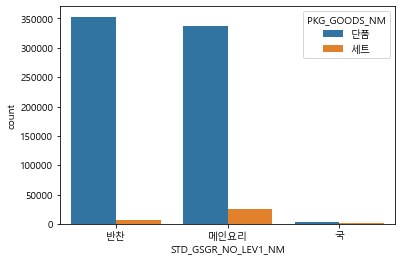

In [89]:
sns.countplot(data=copy_data, x="STD_GSGR_NO_LEV1_NM", hue='PKG_GOODS_NM')

- 큰 차이는 아니지만 예상 외로 메인보다 반찬의 경우가 세트로 팔릴 확률이 높은 것으로 나타났다.
- 국의 경우는 단품과 세트로 사는 경우가 반반이었다.

In [113]:
copy_data['GOODS'].loc[(copy_data['STD_GSGR_NO_LEV1_NM']=='반찬') & (copy_data['PKG_GOODS_NM']=='세트')].value_counts().to_frame()

,GOODS
1806011271_열무비빔밥재료믹스(2인분),2835
1823_숙주나물(300g),971
"2204016772_소고기유니짜장소스(1인분, 200g)",970
1712010310_두메산나물비빔밥재료,395
1909013359_가정집 오징어불고기/셀프(380g),376
1903012675_순살코다리강정(180g),105
3273_채소계란찜(340g),58
1808011751_꼬막무침 (250g),39
1901012353_수제계란말이(350g),32
2010014667_우삼겹숙주볶음(250g),32


- 세트로 팔린 반찬의 경우 주로 메인에 필요한 재료들이 세트로 팔린 것을 확인할 수 있다.
- 정말 반찬으로 소비되는 식품을 세트로 사는 경우는 매우 희박한 것을 확인할 수 있었다.

In [29]:
test_data['DATE_DIFF'] = pd.to_datetime(copy_data['O_YMD']) - pd.to_datetime(copy_data['H_YMD'])

In [33]:
test_data['DATE_DIFF'] = pd.to_numeric(test_data['DATE_DIFF'])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724702 entries, 0 to 724701
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   O_YMD                724702 non-null  object 
 2   PKG_GOODS_NM         724702 non-null  object 
 3   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 4   ORD_QTY              724702 non-null  int64  
 5   CANCEL_QTY           724702 non-null  int64  
 6   RET_QTY              724702 non-null  int64  
 7   REAL_ORD_QTY         724702 non-null  int64  
 8   SALE_PRICE           724702 non-null  int64  
 9   DISCOUNT_AMT         348455 non-null  float64
 10  FINAL_PRICE          724702 non-null  int64  
 11  GOODS                724702 non-null  object 
 12  DATE_DIFF            724702 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 71.9+ MB


In [35]:
test_data['DATE_DIFF']

0        -128030000000000
1         -48251000000000
2         -44488000000000
3        -124689000000000
4         -56619000000000
               ...       
724697   -601768000000000
724698   -217316000000000
724699   -186933000000000
724700   -189585000000000
724701   -204960000000000
Name: DATE_DIFF, Length: 724702, dtype: int64

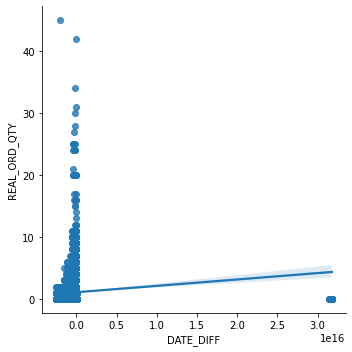

In [34]:
sns.lmplot(x='DATE_DIFF', y='REAL_ORD_QTY', data=test_data)

### 1.4 이변량 분석

## 2. 데이터 전처리

### 2.1 이상치 처리

In [210]:
copy_data.describe()

,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
count,724702.00000,724702.000000,724702.000000,724702.000000,724702.000000,348455.000000,724702.000000
mean,1.12172,0.050588,0.003917,1.071131,7262.438891,1118.631562,6724.572622
std,0.47063,0.286248,0.071317,0.497911,2417.240294,1852.828670,2388.223550
min,1.00000,0.000000,0.000000,0.000000,2600.000000,0.000000,-31390.000000
25%,1.00000,0.000000,0.000000,1.000000,4900.000000,169.000000,4783.000000
50%,1.00000,0.000000,0.000000,1.000000,7000.000000,480.000000,6900.000000
75%,1.00000,0.000000,0.000000,1.000000,8800.000000,1250.000000,8600.000000
max,45.00000,31.000000,7.000000,45.000000,35600.000000,39990.000000,35600.000000


c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-package

<AxesSubplot:xlabel='FINAL_PRICE'>

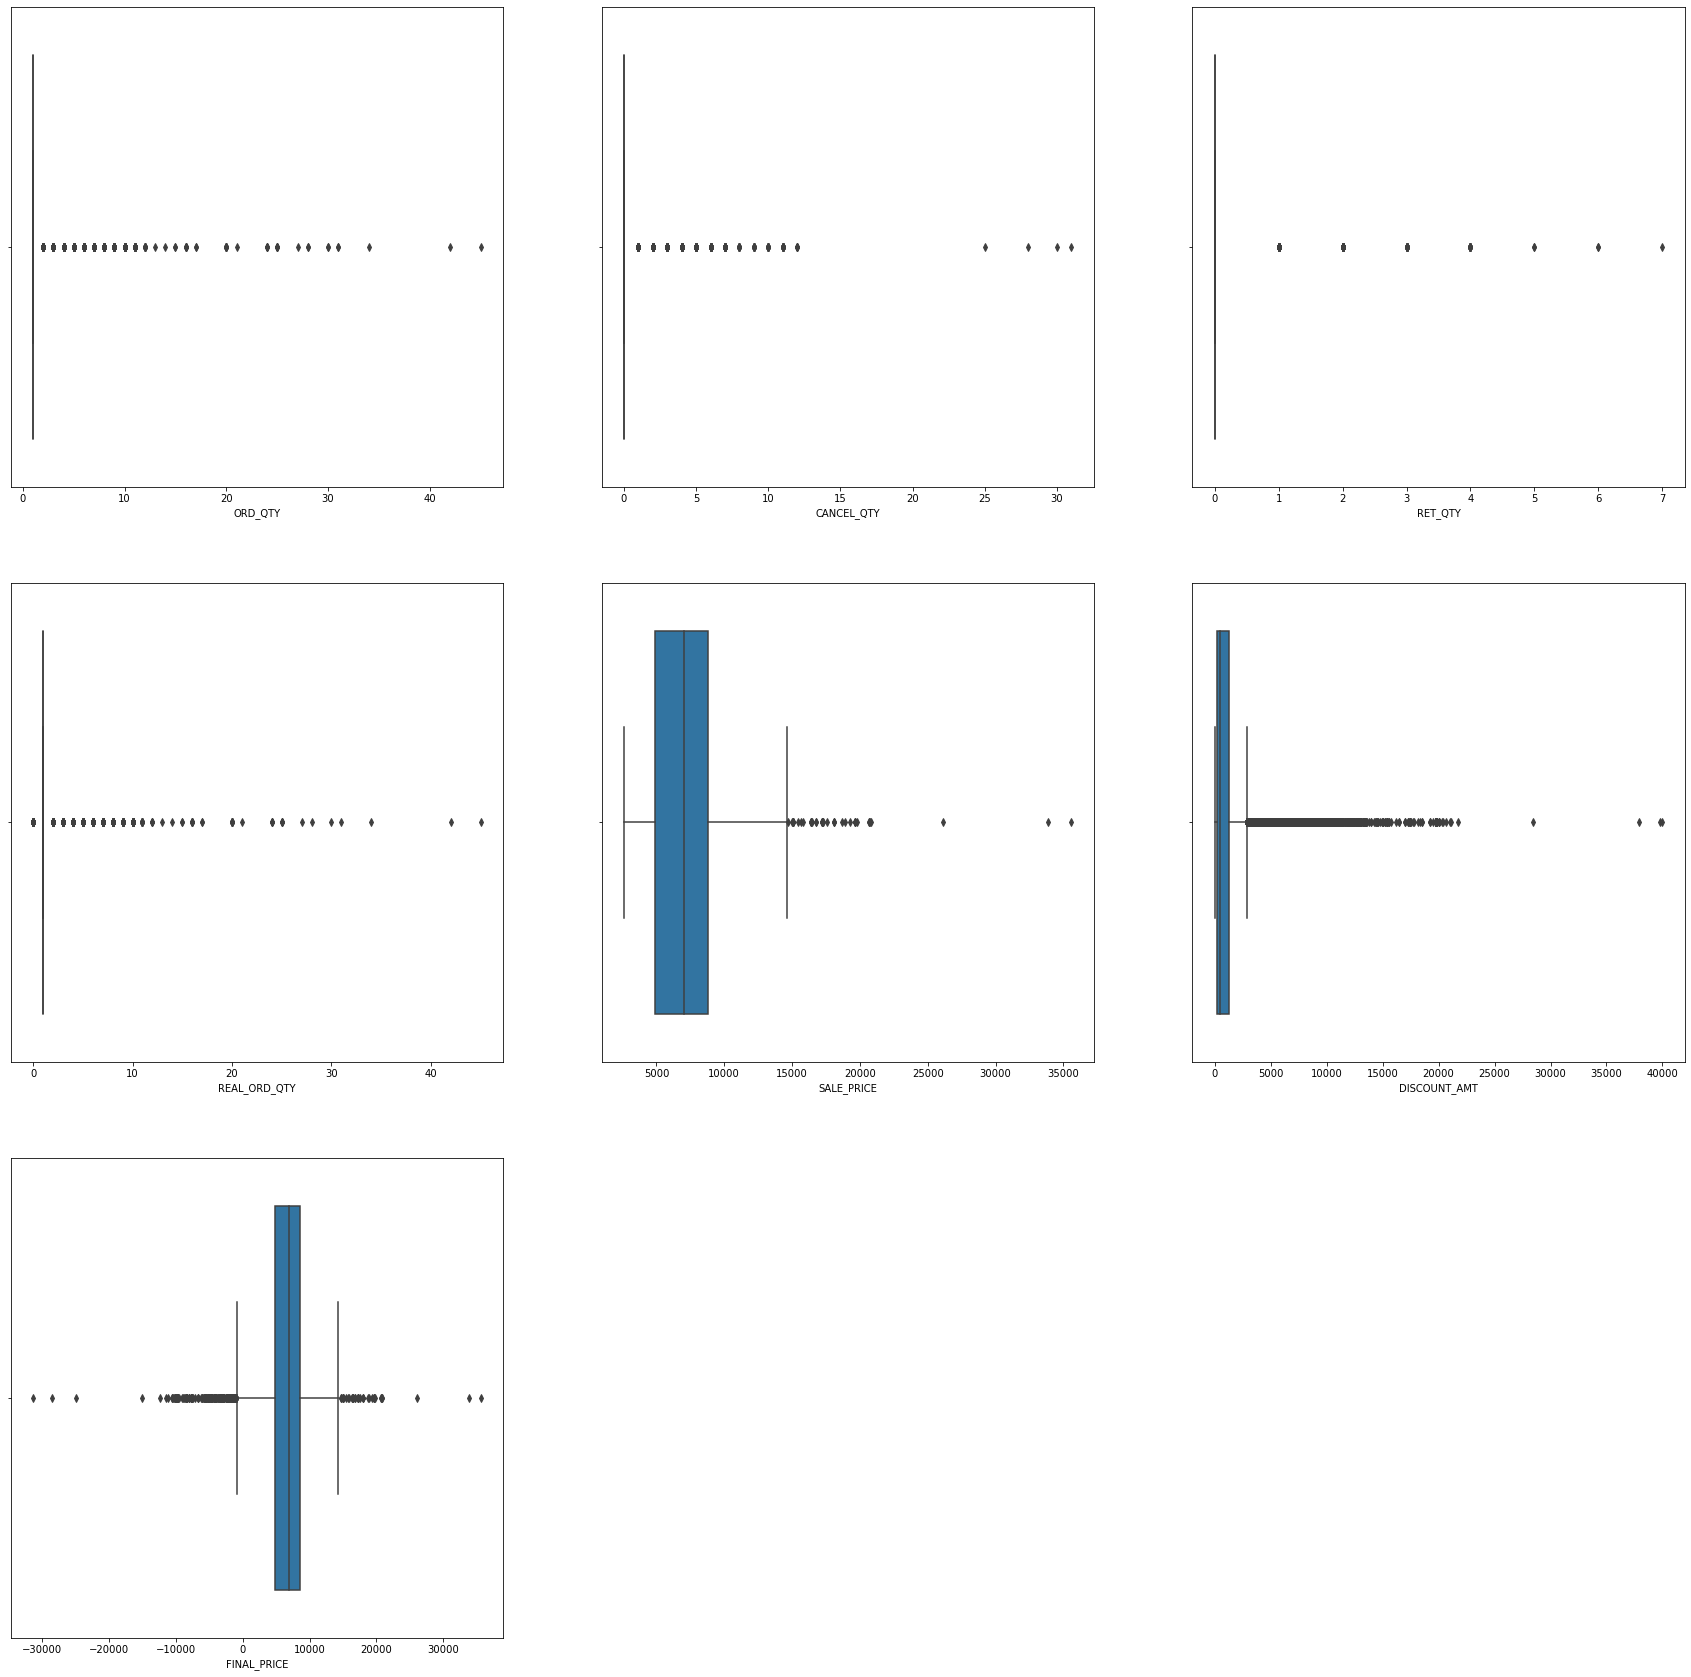

In [12]:
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
sns.boxplot(x='ORD_QTY',  orient = "v", data=copy_data)

plt.subplot(3,3,2)
sns.boxplot(x='CANCEL_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,3)
sns.boxplot(x='RET_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,4)
sns.boxplot(x='REAL_ORD_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,5)
sns.boxplot(x='SALE_PRICE', orient = "v", data=copy_data)

plt.subplot(3,3,6)
sns.boxplot(x='DISCOUNT_AMT', orient = "v", data=copy_data)

plt.subplot(3,3,7)
sns.boxplot(x='FINAL_PRICE', orient = "v", data=copy_data)


In [259]:
q1 = copy_data['ORD_QTY'].quantile(0.25)
q1
q3 = copy_data['ORD_QTY'].quantile(0.75)
q3

1.0

In [211]:
def outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    df.loc[(df[col] > (q3 + 1.5 * iqr)) | (df[col] < (q1 - 1.5 * iqr)), col] = df[col].mean()

In [212]:
ol_col = ['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY', 'SALE_PRICE', 'FINAL_PRICE']

for i in ol_col:
    print(i)
    outlier(copy_data, i)


ORD_QTY
CANCEL_QTY
RET_QTY
REAL_ORD_QTY
SALE_PRICE
FINAL_PRICE


In [199]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   PKG_GOODS_NM         724702 non-null  object 
 2   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 3   ORD_QTY              724702 non-null  float64
 4   CANCEL_QTY           724702 non-null  float64
 5   RET_QTY              724702 non-null  float64
 6   REAL_ORD_QTY         724702 non-null  float64
 7   SALE_PRICE           724702 non-null  float64
 8   DISCOUNT_AMT         348455 non-null  float64
 9   FINAL_PRICE          724702 non-null  float64
dtypes: float64(7), object(3)
memory usage: 60.8+ MB


c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\user\anaconda3\lib\site-package

<AxesSubplot:xlabel='FINAL_PRICE'>

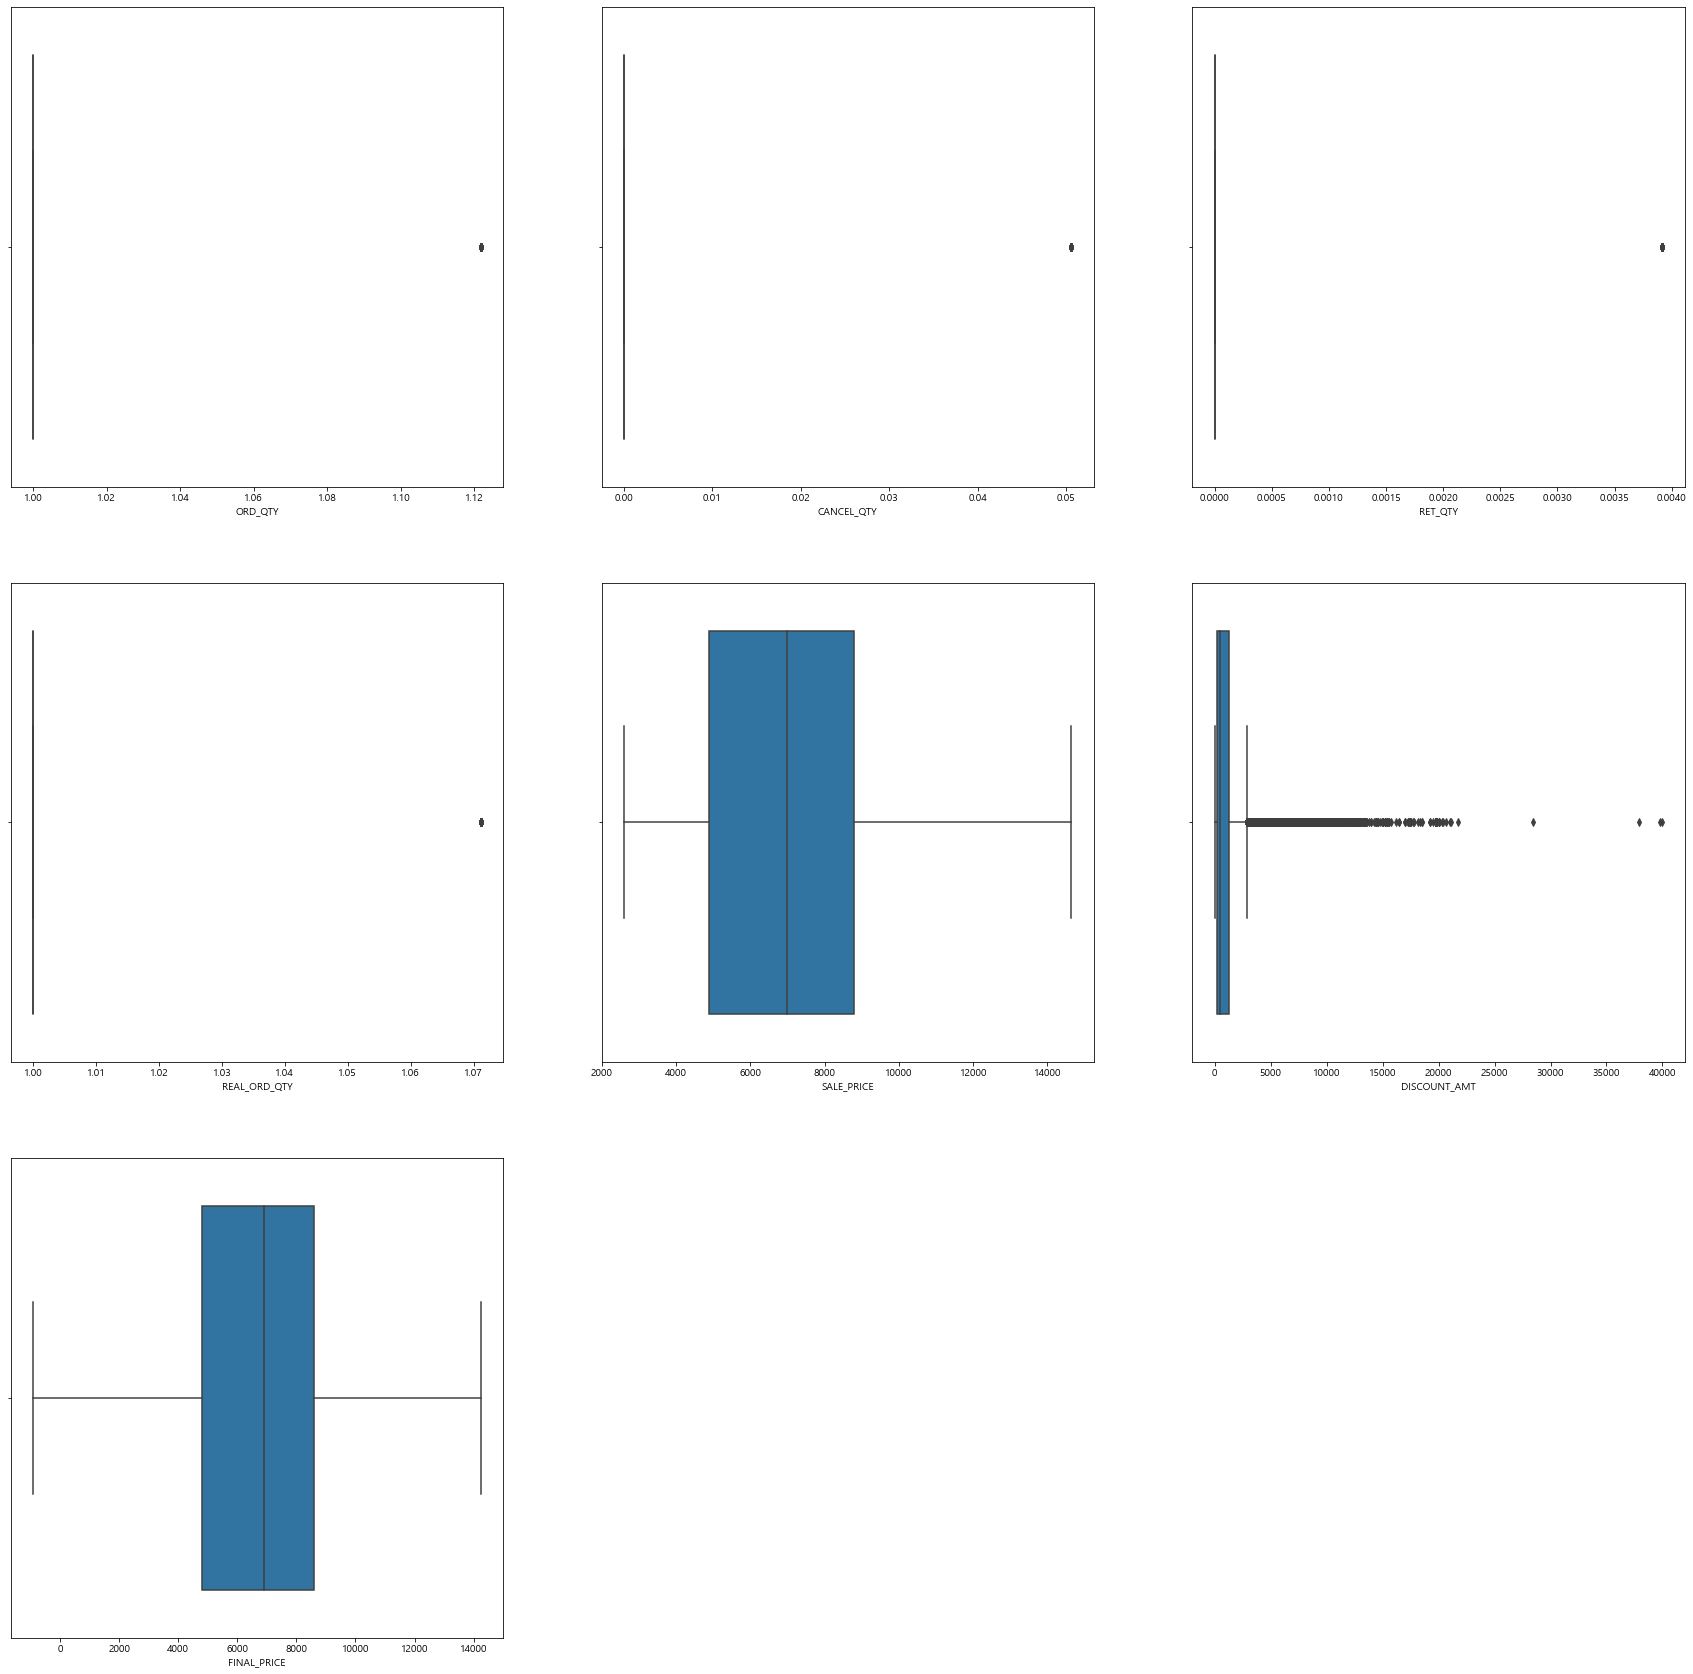

In [213]:
plt.figure(figsize=(30,30))
plt.subplot(3,3,1)
sns.boxplot(x='ORD_QTY',  orient = "v", data=copy_data)

plt.subplot(3,3,2)
sns.boxplot(x='CANCEL_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,3)
sns.boxplot(x='RET_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,4)
sns.boxplot(x='REAL_ORD_QTY', orient = "v", data=copy_data)

plt.subplot(3,3,5)
sns.boxplot(x='SALE_PRICE', orient = "v", data=copy_data)

plt.subplot(3,3,6)
sns.boxplot(x='DISCOUNT_AMT', orient = "v", data=copy_data)

plt.subplot(3,3,7)
sns.boxplot(x='FINAL_PRICE', orient = "v", data=copy_data)


c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='REAL_ORD_QTY', ylabel='Density'>

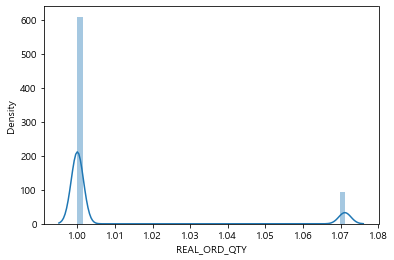

In [266]:
sns.distplot(copy_data['REAL_ORD_QTY'])

In [312]:
copy_data.isna().sum()

H_YMD                  0
PKG_GOODS_NM           0
STD_GSGR_NO_LEV1_NM    0
ORD_QTY                0
CANCEL_QTY             0
RET_QTY                0
REAL_ORD_QTY           0
SALE_PRICE             0
DISCOUNT_AMT           0
FINAL_PRICE            0
GOODS                  0
dtype: int64

In [311]:
copy_data['DISCOUNT_AMT'].fillna(0, inplace=True)

In [313]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   H_YMD                724702 non-null  object 
 1   PKG_GOODS_NM         724702 non-null  object 
 2   STD_GSGR_NO_LEV1_NM  724702 non-null  object 
 3   ORD_QTY              724702 non-null  int64  
 4   CANCEL_QTY           724702 non-null  int64  
 5   RET_QTY              724702 non-null  int64  
 6   REAL_ORD_QTY         724702 non-null  int64  
 7   SALE_PRICE           724702 non-null  int64  
 8   DISCOUNT_AMT         724702 non-null  float64
 9   FINAL_PRICE          724702 non-null  int64  
 10  GOODS                724702 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 66.3+ MB


### 2.3 가변수화

In [314]:
cols = ['PKG_GOODS_NM', 'STD_GSGR_NO_LEV1_NM', 'GOODS']

copy_data= pd.get_dummies(copy_data, columns = cols ,drop_first = True)

### 2.4 주 별 데이터로 묶기

In [315]:
copy_data

,H_YMD,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_세트,STD_GSGR_NO_LEV1_NM_메인요리,...,GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231_[심방골주부X더반찬] 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
166288,2020-01-01 00:00:00,1,0,0,1,8600,1408.0,7192,0,1,...,0,0,0,0,0,0,0,0,0,0
37753,2020-01-01 00:00:00,2,0,0,2,6300,0.0,6300,0,0,...,1,0,0,0,0,0,0,0,0,0
162585,2020-01-01 00:00:00,1,0,0,1,3300,486.0,2814,0,0,...,0,0,0,0,0,0,0,0,0,0
164041,2020-01-01 00:00:00,1,0,0,1,6900,264.0,6636,0,1,...,0,0,0,0,0,0,0,0,0,0
164040,2020-01-01 00:00:00,1,0,0,1,6900,317.0,6583,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,1,0,0,1,4500,0.0,4500,0,1,...,0,0,0,0,0,0,0,0,0,0
241774,2022-05-31 00:00:00,1,0,0,1,9900,1801.0,8099,0,1,...,0,0,1,0,0,0,0,0,0,0
236656,2022-05-31 00:00:00,1,0,0,1,4500,0.0,4500,0,1,...,0,0,0,0,0,0,0,0,0,0
241810,2022-05-31 00:00:00,1,0,0,1,9900,1490.0,8410,0,1,...,0,0,1,0,0,0,0,0,0,0


In [316]:
copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])

In [317]:
resampled = copy_data.resample(rule='1W', on='H_YMD')
resampled.sum()

copy_data = resampled.sum()

In [318]:
copy_data

,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_세트,STD_GSGR_NO_LEV1_NM_메인요리,STD_GSGR_NO_LEV1_NM_반찬,...,GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231_[심방골주부X더반찬] 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
H_YMD,,,,,,,,,,,,,,,,,,,,,
2020-01-05,2473,146,3,2327,15276300,445544.0,14830756,4.0,1150.0,1057.0,...,91.0,62.0,65.0,0.0,0.0,0.0,0.0,0.0,127.0,75.0
2020-01-12,4194,210,4,3984,25869300,818906.0,25050394,6.0,1960.0,1850.0,...,186.0,94.0,103.0,0.0,0.0,0.0,0.0,0.0,251.0,138.0
2020-01-19,3439,193,9,3246,21531500,1353214.0,20178286,4.0,1814.0,1312.0,...,1.0,81.0,95.0,0.0,0.0,0.0,0.0,0.0,10.0,180.0
2020-01-26,4463,312,13,4151,27642900,906740.0,26736160,91.0,2517.0,1164.0,...,0.0,67.0,105.0,0.0,0.0,0.0,0.0,0.0,6.0,119.0
2020-02-02,2521,95,6,2426,15042100,353598.0,14688502,11.0,1074.0,1230.0,...,59.0,93.0,86.0,0.0,0.0,0.0,0.0,0.0,90.0,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,6923,249,37,6674,43461860,3956951.0,39504909,260.0,2143.0,3745.0,...,226.0,182.0,176.0,122.0,130.0,357.0,183.0,307.0,394.0,253.0
2022-05-15,7243,185,16,7058,44551710,3899804.0,40651906,308.0,2083.0,4118.0,...,308.0,377.0,183.0,133.0,233.0,294.0,215.0,294.0,412.0,233.0
2022-05-22,6957,200,22,6757,43893380,3416661.0,40476719,221.0,1999.0,3965.0,...,299.0,331.0,172.0,148.0,155.0,278.0,174.0,274.0,449.0,159.0


In [100]:
copy_data.to_csv('C:\\Users\\user\\Desktop\\raw.csv', index=False, encoding='utf-8-sig')

### 2.2 target, feature 분리

In [333]:
copy_data.dropna(inplace=True)

In [334]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

copy_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in copy_data.columns.values]

In [335]:
train_data = copy_data[:121]
test_data = copy_data[121:]

test_data.head()

,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,PKG_GOODS_NM_세트,STD_GSGR_NO_LEV1_NM_메인요리,STD_GSGR_NO_LEV1_NM_반찬,...,GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
H_YMD,,,,,,,,,,,,,,,,,,,,,
2022-05-01,7392,250,40,7142,46621200,4610151.0,42011049,316.0,2013.0,4387.0,...,323.0,209.0,191.0,124.0,142.0,328.0,163.0,389.0,470.0,308.0
2022-05-08,6923,249,37,6674,43461860,3956951.0,39504909,260.0,2143.0,3745.0,...,226.0,182.0,176.0,122.0,130.0,357.0,183.0,307.0,394.0,253.0
2022-05-15,7243,185,16,7058,44551710,3899804.0,40651906,308.0,2083.0,4118.0,...,308.0,377.0,183.0,133.0,233.0,294.0,215.0,294.0,412.0,233.0
2022-05-22,6957,200,22,6757,43893380,3416661.0,40476719,221.0,1999.0,3965.0,...,299.0,331.0,172.0,148.0,155.0,278.0,174.0,274.0,449.0,159.0
2022-05-29,7836,1494,7,6342,43655170,3195566.0,40459604,255.0,1990.0,3968.0,...,267.0,183.0,109.0,137.0,141.0,336.0,145.0,265.0,379.0,216.0


In [336]:
train_data.columns

Index(['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY', 'SALE_PRICE',
       'DISCOUNT_AMT', 'FINAL_PRICE', 'PKG_GOODS_NM_세트',
       'STD_GSGR_NO_LEV1_NM_메인요리', 'STD_GSGR_NO_LEV1_NM_반찬',
       'GOODS_13957_셀프두부조림(600g)', 'GOODS_14375_옛날잡채(500g)', 'GOODS_14985_양장피',
       'GOODS_1712010310_두메산나물비빔밥재료', 'GOODS_1803010879_고소한도토리묵무침(265g)',
       'GOODS_1803010879_고소한도토리묵무침(360g)', 'GOODS_1805011121_건고사리나물볶음(150g)',
       'GOODS_1805011121_고사리나물볶음(150g)', 'GOODS_1806011271_열무비빔밥재료믹스(2인분)',
       'GOODS_1808011751_꼬막무침 (250g)', 'GOODS_1808011751_꼬막무침 (260g)',
       'GOODS_1823_숙주나물(300g)', 'GOODS_1901012353_수제계란말이(350g)',
       'GOODS_1903012675_순살코다리강정(180g)',
       'GOODS_1909013359_가정집 오징어불고기/셀프(380g)',
       'GOODS_2010014667_우삼겹숙주볶음(250g)', 'GOODS_2010014707_고구마 품은 라자냐(450g)',
       'GOODS_2012014895_한돈 제육볶음(700g)',
       'GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_2204016772_소고기유니짜장소스(1인분, 200g)', 'GOODS_3273_채소계란찜(340g)',
       'GOODS_4092_건표고버섯볶음'],


In [337]:
target = ['GOODS_13957_셀프두부조림(600g)', 'GOODS_14375_옛날잡채(500g)', 'GOODS_14985_양장피',
       'GOODS_1712010310_두메산나물비빔밥재료',
       'GOODS_1803010879_고소한도토리묵무침(360g)',
       'GOODS_1805011121_고사리나물볶음(150g)', 'GOODS_1806011271_열무비빔밥재료믹스(2인분)',
       'GOODS_1808011751_꼬막무침 (260g)',
       'GOODS_1823_숙주나물(300g)', 'GOODS_1901012353_수제계란말이(350g)',
       'GOODS_1903012675_순살코다리강정(180g)',
       'GOODS_1909013359_가정집 오징어불고기/셀프(380g)',
       'GOODS_2010014667_우삼겹숙주볶음(250g)', 'GOODS_2010014707_고구마 품은 라자냐(450g)',
       'GOODS_2012014895_한돈 제육볶음(700g)',
       'GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_2204016772_소고기유니짜장소스(1인분, 200g)', 'GOODS_3273_채소계란찜(340g)',
       'GOODS_4092_건표고버섯볶음']
X, X_test = copy_data[:121].drop(target, axis=1), copy_data[121:].drop(target, axis=1)
y, y_test = copy_data[:121][target], copy_data[121:][target]

In [338]:
y_test

,GOODS_13957_셀프두부조림(600g),GOODS_14375_옛날잡채(500g),GOODS_14985_양장피,GOODS_1712010310_두메산나물비빔밥재료,GOODS_1803010879_고소한도토리묵무침(360g),GOODS_1805011121_고사리나물볶음(150g),GOODS_1806011271_열무비빔밥재료믹스(2인분),GOODS_1808011751_꼬막무침 (260g),GOODS_1823_숙주나물(300g),GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
H_YMD,,,,,,,,,,,,,,,,,,,
2022-05-01,478.0,743.0,310.0,1230.0,299.0,114.0,0.0,355.0,387.0,323.0,209.0,191.0,124.0,142.0,328.0,163.0,389.0,470.0,308.0
2022-05-08,447.0,768.0,339.0,1068.0,373.0,148.0,0.0,234.0,364.0,226.0,182.0,176.0,122.0,130.0,357.0,183.0,307.0,394.0,253.0
2022-05-15,467.0,688.0,236.0,1062.0,449.0,181.0,0.0,250.0,401.0,308.0,377.0,183.0,133.0,233.0,294.0,215.0,294.0,412.0,233.0
2022-05-22,446.0,687.0,292.0,1000.0,320.0,183.0,136.0,202.0,338.0,299.0,331.0,172.0,148.0,155.0,278.0,174.0,274.0,449.0,159.0
2022-05-29,419.0,537.0,240.0,800.0,280.0,193.0,316.0,176.0,617.0,267.0,183.0,109.0,137.0,141.0,336.0,145.0,265.0,379.0,216.0
2022-06-05,124.0,177.0,54.0,251.0,97.0,50.0,81.0,42.0,127.0,102.0,40.0,48.0,57.0,46.0,83.0,51.0,93.0,136.0,70.0


### 2.4 추가 옵션 도출(feature Engineering)

### 2.5 데이터 분할

In [339]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, random_state = 2022)

In [340]:
X_train.shape

(84, 13)

### 2.6 스케일링

In [341]:
from sklearn.preprocessing import MinMaxScaler
col_x = list(X)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

## 3. 모델링

- XGBoost 모델

In [181]:
!pip install xgboost

In [224]:
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

In [225]:
model = XGBRegressor(
    max_depth=4,
    n_estimators=1000,
    min_child_weight=500, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    objective= 'reg:linear')

In [226]:
model.fit(
    X_train_s, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train_s, y_train), (X_val_s, y_val)], 
    verbose=True, 
    early_stopping_rounds = 50)

[13:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[1]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[2]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[3]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[4]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[5]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[6]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[7]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[8]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[9]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[10]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[11]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[12]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[13]	validatio

c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[48]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953
[49]	validation_0-rmse:5893.90687	validation_1-rmse:6131.56953


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=500,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=42, ...)

In [227]:
Y_pred = model.predict(X_test)

In [228]:
r2 = r2_score(y_test, Y_pred)
r2

-11.093347457298625

In [229]:
Y_pred

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)

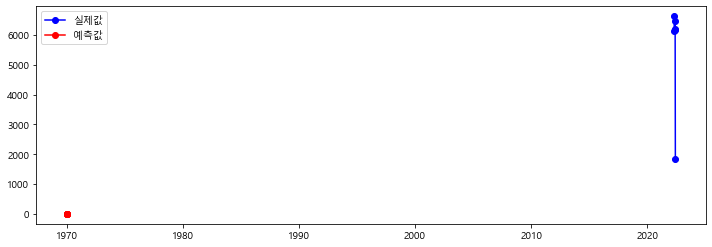

In [230]:
fig = plt.figure(figsize=(12,4))
chart = fig.add_subplot(1,1,1)
chart.plot(y_test[:200], marker='o', color='b', label='실제값')
chart.plot(Y_pred[:200], marker='o', color='r', label='예측값')
plt.legend(loc='best')

In [180]:
X_test['y_test'] = y_test
X_test['y_pred'] = Y_pred

X_test['H_YMD'] = pd.to_datetime(X_test['H_YMD'])
X_test.to_csv('C:\\Users\\user\\Desktop\\result.csv', encoding='utf-8-sig')

- RandomForesting

In [342]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100,
                                      min_samples_split=2,
                                      random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [347]:
rf_y_pred = rf_model.predict(X_val)

rf_y_pred

array([[3.34780e+02, 7.66520e+02, 1.67230e+02, 1.15873e+03, 0.00000e+00,
        1.95000e+00, 1.98890e+02, 4.12000e+00, 2.51080e+02, 2.19850e+02,
        1.64900e+01, 2.49340e+02, 1.19800e+01, 1.47800e+01, 2.80400e+01,
        8.58000e+00, 0.00000e+00, 2.91440e+02, 1.58080e+02],
       [4.22210e+02, 9.88750e+02, 2.44850e+02, 1.34605e+03, 2.80500e+01,
        2.36700e+01, 3.39000e+01, 7.16800e+01, 3.76450e+02, 2.79940e+02,
        1.30140e+02, 2.28740e+02, 1.96970e+02, 2.05020e+02, 1.41030e+02,
        3.68600e+01, 5.54000e+00, 3.04410e+02, 2.61620e+02],
       [4.26930e+02, 9.81220e+02, 2.24860e+02, 1.14397e+03, 0.00000e+00,
        9.10000e+00, 4.73000e+00, 1.43200e+01, 4.35590e+02, 3.41350e+02,
        1.81360e+02, 1.57260e+02, 1.40540e+02, 1.65840e+02, 3.73210e+02,
        2.07980e+02, 0.00000e+00, 2.99590e+02, 2.77190e+02],
       [3.39710e+02, 6.96980e+02, 1.45170e+02, 1.11530e+03, 0.00000e+00,
        0.00000e+00, 1.49050e+02, 0.00000e+00, 2.50100e+02, 2.30300e+02,
        6.4400

In [234]:
# import joblib

# joblib.dump(rf_model, 'rf_model_0706.pkl')

In [345]:
X_test.columns

Index(['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY', 'SALE_PRICE',
       'DISCOUNT_AMT', 'FINAL_PRICE', 'PKG_GOODS_NM_세트',
       'STD_GSGR_NO_LEV1_NM_메인요리', 'STD_GSGR_NO_LEV1_NM_반찬',
       'GOODS_1803010879_고소한도토리묵무침(265g)', 'GOODS_1805011121_건고사리나물볶음(150g)',
       'GOODS_1808011751_꼬막무침 (250g)'],
      dtype='object')

In [349]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, rf_y_pred)
r2

0.4970020308990349

In [330]:
y_test

,GOODS_13957_셀프두부조림(600g),GOODS_14375_옛날잡채(500g),GOODS_14985_양장피,GOODS_1712010310_두메산나물비빔밥재료,GOODS_1803010879_고소한도토리묵무침(360g),GOODS_1805011121_고사리나물볶음(150g),GOODS_1806011271_열무비빔밥재료믹스(2인분),GOODS_1808011751_꼬막무침 (260g),GOODS_1823_숙주나물(300g),GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
H_YMD,,,,,,,,,,,,,,,,,,,
2022-05-01,478.0,743.0,310.0,1230.0,299.0,114.0,0.0,355.0,387.0,323.0,209.0,191.0,124.0,142.0,328.0,163.0,389.0,470.0,308.0
2022-05-08,447.0,768.0,339.0,1068.0,373.0,148.0,0.0,234.0,364.0,226.0,182.0,176.0,122.0,130.0,357.0,183.0,307.0,394.0,253.0
2022-05-15,467.0,688.0,236.0,1062.0,449.0,181.0,0.0,250.0,401.0,308.0,377.0,183.0,133.0,233.0,294.0,215.0,294.0,412.0,233.0
2022-05-22,446.0,687.0,292.0,1000.0,320.0,183.0,136.0,202.0,338.0,299.0,331.0,172.0,148.0,155.0,278.0,174.0,274.0,449.0,159.0
2022-05-29,419.0,537.0,240.0,800.0,280.0,193.0,316.0,176.0,617.0,267.0,183.0,109.0,137.0,141.0,336.0,145.0,265.0,379.0,216.0
2022-06-05,124.0,177.0,54.0,251.0,97.0,50.0,81.0,42.0,127.0,102.0,40.0,48.0,57.0,46.0,83.0,51.0,93.0,136.0,70.0


In [359]:
Y_test = test_data[['GOODS_13957_셀프두부조림(600g)', 'GOODS_14375_옛날잡채(500g)', 'GOODS_14985_양장피',
       'GOODS_1712010310_두메산나물비빔밥재료',
       'GOODS_1803010879_고소한도토리묵무침(360g)',
       'GOODS_1805011121_고사리나물볶음(150g)', 'GOODS_1806011271_열무비빔밥재료믹스(2인분)',
       'GOODS_1808011751_꼬막무침 (260g)',
       'GOODS_1823_숙주나물(300g)', 'GOODS_1901012353_수제계란말이(350g)',
       'GOODS_1903012675_순살코다리강정(180g)',
       'GOODS_1909013359_가정집 오징어불고기/셀프(380g)',
       'GOODS_2010014667_우삼겹숙주볶음(250g)', 'GOODS_2010014707_고구마 품은 라자냐(450g)',
       'GOODS_2012014895_한돈 제육볶음(700g)',
       'GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_2204016772_소고기유니짜장소스(1인분, 200g)', 'GOODS_3273_채소계란찜(340g)',
       'GOODS_4092_건표고버섯볶음']]

Y_test

,GOODS_13957_셀프두부조림(600g),GOODS_14375_옛날잡채(500g),GOODS_14985_양장피,GOODS_1712010310_두메산나물비빔밥재료,GOODS_1803010879_고소한도토리묵무침(360g),GOODS_1805011121_고사리나물볶음(150g),GOODS_1806011271_열무비빔밥재료믹스(2인분),GOODS_1808011751_꼬막무침 (260g),GOODS_1823_숙주나물(300g),GOODS_1901012353_수제계란말이(350g),GOODS_1903012675_순살코다리강정(180g),GOODS_1909013359_가정집 오징어불고기/셀프(380g),GOODS_2010014667_우삼겹숙주볶음(250g),GOODS_2010014707_고구마 품은 라자냐(450g),GOODS_2012014895_한돈 제육볶음(700g),GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g),"GOODS_2204016772_소고기유니짜장소스(1인분, 200g)",GOODS_3273_채소계란찜(340g),GOODS_4092_건표고버섯볶음
H_YMD,,,,,,,,,,,,,,,,,,,
2022-05-01,478.0,743.0,310.0,1230.0,299.0,114.0,0.0,355.0,387.0,323.0,209.0,191.0,124.0,142.0,328.0,163.0,389.0,470.0,308.0
2022-05-08,447.0,768.0,339.0,1068.0,373.0,148.0,0.0,234.0,364.0,226.0,182.0,176.0,122.0,130.0,357.0,183.0,307.0,394.0,253.0
2022-05-15,467.0,688.0,236.0,1062.0,449.0,181.0,0.0,250.0,401.0,308.0,377.0,183.0,133.0,233.0,294.0,215.0,294.0,412.0,233.0
2022-05-22,446.0,687.0,292.0,1000.0,320.0,183.0,136.0,202.0,338.0,299.0,331.0,172.0,148.0,155.0,278.0,174.0,274.0,449.0,159.0
2022-05-29,419.0,537.0,240.0,800.0,280.0,193.0,316.0,176.0,617.0,267.0,183.0,109.0,137.0,141.0,336.0,145.0,265.0,379.0,216.0
2022-06-05,124.0,177.0,54.0,251.0,97.0,50.0,81.0,42.0,127.0,102.0,40.0,48.0,57.0,46.0,83.0,51.0,93.0,136.0,70.0


In [360]:
#rf_y_pred = pd.DataFrame(rf_y_pred, columns=['REAL_ORD_QTY'])

#rf_y_pred.REAL_ORD_QTY
Y_test['GOODS_13957_셀프두부조림(600g)', 'GOODS_14375_옛날잡채(500g)', 'GOODS_14985_양장피',
       'GOODS_1712010310_두메산나물비빔밥재료',
       'GOODS_1803010879_고소한도토리묵무침(360g)',
       'GOODS_1805011121_고사리나물볶음(150g)', 'GOODS_1806011271_열무비빔밥재료믹스(2인분)',
       'GOODS_1808011751_꼬막무침 (260g)',
       'GOODS_1823_숙주나물(300g)', 'GOODS_1901012353_수제계란말이(350g)',
       'GOODS_1903012675_순살코다리강정(180g)',
       'GOODS_1909013359_가정집 오징어불고기/셀프(380g)',
       'GOODS_2010014667_우삼겹숙주볶음(250g)', 'GOODS_2010014707_고구마 품은 라자냐(450g)',
       'GOODS_2012014895_한돈 제육볶음(700g)',
       'GOODS_2103015231__심방골주부X더반찬_ 시골 돼지짜글이(600g)',
       'GOODS_2204016772_소고기유니짜장소스(1인분, 200g)', 'GOODS_3273_채소계란찜(340g)',
       'GOODS_4092_건표고버섯볶음'] = rf_y_pred

Y_test

ValueError: Length of values (37) does not match length of index (6)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


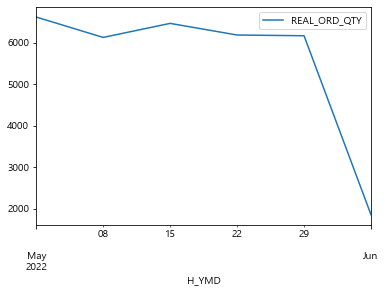

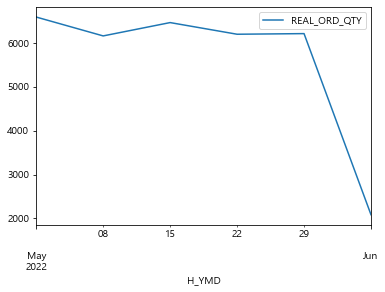

In [240]:
print(y_test.plot())
print(Y_test.plot())

feature ranking
1. feature ORD_QTY ( 0.793)
2. feature FINAL_PRICE ( 0.003)
3. feature SALE_PRICE ( 0.001)
4. feature STD_GSGR_NO_LEV1_NM_메인요리 ( 0.066)
5. feature GOODS_1712010310_두메산나물비빔밥재료 ( 0.003)
6. feature STD_GSGR_NO_LEV1_NM_반찬 ( 0.083)
7. feature GOODS_1823_숙주나물(300g) ( 0.003)
8. feature GOODS_1909013359_가정집 오징어불고기/셀프(380g) ( 0.009)
9. feature PKG_GOODS_NM_세트 ( 0.007)
10. feature CANCEL_QTY ( 0.001)
11. feature DISCOUNT_AMT ( 0.003)
12. feature GOODS_14375_옛날잡채(500g) ( 0.001)
13. feature GOODS_2012014895_한돈 제육볶음(700g) ( 0.009)
14. feature GOODS_1901012353_수제계란말이(350g) ( 0.001)
15. feature RET_QTY ( 0.000)
16. feature GOODS_1803010879_고소한도토리묵무침(265g) ( 0.001)
17. feature GOODS_13957_셀프두부조림(600g) ( 0.000)
18. feature GOODS_1805011121_건고사리나물볶음(150g) ( 0.001)
19. feature GOODS_1806011271_열무비빔밥재료믹스(2인분) ( 0.001)
20. feature GOODS_14985_양장피 ( 0.000)
21. feature GOODS_3273_채소계란찜(340g) ( 0.005)
22. feature GOODS_1808011751_꼬막무침 (250g) ( 0.002)
23. feature GOODS_1903012675_순살코다리강정(180g) 

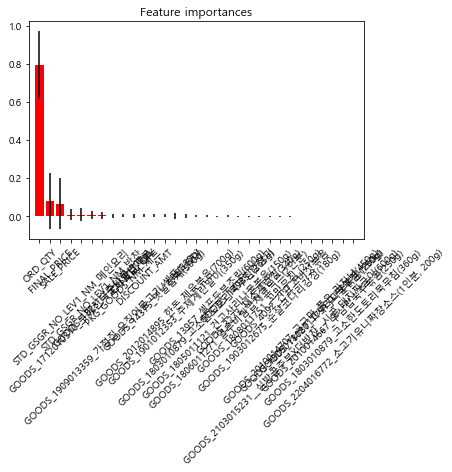

In [244]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('feature ranking')

for f in range(X_train.shape[1]):
    print('{}. feature {} ({: .3f})'.format(f + 1, X_train.columns[indices][f], importances[f]))

plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### 3.2 딥러닝 모델

## 4. 성능 비교

## 5. 비지니스 인사이트 도출